<a href="https://colab.research.google.com/github/cesphamm/procesamiento_lenguaje_natural/blob/main/Desafio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### 1 - Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

Aumento MAX_NUM_SENTENCES a la totalidad de los datos.

In [1]:
#!python3 -m pip install 'tensorflow[and-cuda]'
#!pip install tensorflow==2.12
#!pip install keras_preprocessing
#!pip install keras

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import re

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, LSTM, SimpleRNN, Input
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from keras.utils import to_categorical
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

In [4]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2576k  100 2576k    0     0  1766k      0  0:00:01  0:00:01 --:--:-- 1767k


In [5]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Ahora podemos usar más datos gracias al DataGenerator
# que carga los batches on-the-fly sin consumir toda la RAM
MAX_NUM_SENTENCES = 118964 #50000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964


In [6]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento
Aumento MAX_VOCAB_SIZE a 25000.

In [7]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 25000
# Vamos a necesitar un tokenizador para cada idioma

In [8]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> el número máximo de palabras a conservar, en función de la frecuencia de las palabras.
# - Solo se conservarán las num_words-1 palabras más comunes.

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47


In [9]:
# tokenizador de español
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [ ]:
max_input_len = 16
max_out_len = 18

A la hora de realiza padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [11]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 16)
decoder_input_sequences shape: (118964, 18)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [12]:
# Ya no creamos decoder_targets completo en memoria
# Solo guardamos las secuencias de índices, el one-hot se genera en el DataGenerator
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (118964, 18)


#### Creo DataGenerator para optimizar el uso de RAM

El problema principal de memoria es que `decoder_targets` (el one-hot encoding de las salidas) consume muchísima RAM:

El `DataGenerator`:
1. Hereda de `keras.utils.Sequence` para integrarse con Keras.
2. Solo genera el one-hot encoding para cada batch (64 muestras en lugar de 50,000).
3. El batch en one-hot ocupa solo una parte en lugar de la cantidad de GB que hacían que la RAM no aguante.
4. Permite mezclar los datos (shuffle) al final de cada época.


In [13]:
class DataGenerator(Sequence):
    """
    DataGenerator para el modelo de traducción seq2seq.
    Genera batches on-the-fly para evitar cargar todo el dataset en RAM.
    El one-hot encoding se realiza solo para cada batch, ahorrando memoria.
    """

    def __init__(self, encoder_input, decoder_input, decoder_output,
                 num_words_output, batch_size=32, shuffle=True):
        """
        Args:
            encoder_input: Secuencias de entrada del encoder (ya con padding)
            decoder_input: Secuencias de entrada del decoder (ya con padding)
            decoder_output: Secuencias de salida del decoder (índices, NO one-hot)
            num_words_output: Tamaño del vocabulario de salida (para one-hot)
            batch_size: Tamaño del batch
            shuffle: Si mezclar los datos al final de cada época
        """
        super().__init__()
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.decoder_output = decoder_output
        self.num_words_output = num_words_output
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.encoder_input))

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        """Retorna el número de batches por época"""
        return int(np.ceil(len(self.encoder_input) / self.batch_size))

    def __getitem__(self, idx):
        """Genera un batch de datos"""
        # Obtener los índices para este batch
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Extraer los datos para este batch
        encoder_batch = self.encoder_input[batch_indices]
        decoder_input_batch = self.decoder_input[batch_indices]
        decoder_output_batch = self.decoder_output[batch_indices]

        # Convertir la salida a one-hot encoding SOLO para este batch
        # Esto es lo que ahorra la mayor cantidad de RAM
        decoder_targets_batch = to_categorical(decoder_output_batch,
                                               num_classes=self.num_words_output)

        # Retornar como tupla de arrays numpy (no lista)
        return (encoder_batch, decoder_input_batch), decoder_targets_batch

    def on_epoch_end(self):
        """Se ejecuta al final de cada época"""
        if self.shuffle:
            np.random.shuffle(self.indices)

#### Uso create_tf_dataset en vez de DataGenerator para entrenar más rápido
El entrenamiento con create_tf_dataset es aproximadamente un 18-20% más rápido.

Razones técnicas:
- Prefetching asíncrono: Con `prefetch(tf.data.AUTOTUNE)`, TensorFlow carga el siguiente batch mientras el modelo entrena con el batch actual. Esto elimina el tiempo de espera entre batches.
- Paralelización del preprocesamiento: El `num_parallel_calls=tf.data.AUTOTUNE` permite que múltiples batches se procesen en paralelo usando múltiples threads de CPU. TensorFlow automáticamente determina el número óptimo de threads.
- One-hot encoding en GPU vs CPU: create_tf_dataset usa `tf.one_hot()`, mientras que DataGenerator usa `to_categorical()` de Keras. `tf.one_hot()` puede ejecutarse directamente en GPU, mientras que `to_categorical()` opera en CPU y luego hay que transferir los datos a la GPU.


In [ ]:
def create_tf_dataset(encoder_input, decoder_input, decoder_output,
                      num_words_output, batch_size=64, shuffle=True):

    def generator():
        indices = np.arange(len(encoder_input))
        if shuffle:
            np.random.shuffle(indices)
        for i in indices:
            yield (encoder_input[i], decoder_input[i]), decoder_output[i]

    # Crear dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (tf.TensorSpec(shape=(None,), dtype=tf.int32),
             tf.TensorSpec(shape=(None,), dtype=tf.int32)),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )

    # Batch + one-hot encoding en GPU
    def process_batch(x, y):
        encoder, decoder = x
        y_onehot = tf.one_hot(y, depth=num_words_output)
        return (encoder, decoder), y_onehot

    dataset = dataset.batch(batch_size)
    dataset = dataset.map(process_batch, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch mientras entrena

    return dataset


### 3 - Preparar los embeddings

In [16]:
#import sys
#!{sys.executable} -m pip install gdown


In [17]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=1d2b51eb-117f-4fff-9687-a2a86909766d
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:08<00:00, 61.7MB/s]


In [18]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

#!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [19]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [20]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [21]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

if embedding_matrix.shape[0] < (np.max(encoder_input_sequences) + 1):
    diff = (np.max(encoder_input_sequences) + 1) - embedding_matrix.shape[0]
    embedding_matrix = np.vstack([embedding_matrix,
                                  np.zeros((diff, embedding_matrix.shape[1]))])

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 219


In [22]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(13525, 50)

### 4 - Entrenar el modelo

#### Construir modelos

In [23]:
max_input_len

16

Construyo modelos parametrizados por el número de unidades LSTM. Pruebo 64, 128 y 256 unidades.

In [ ]:

def build_traductor_model(n_units=128, encoder_input_sequences_m=None, embedding_matrix_m=None):

    # define training encoder
    encoder_inputs = Input(shape=(max_input_len,))

    #encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

    encoder_input_sequences_m = np.clip(
        encoder_input_sequences_m,
        0,
        embedding_matrix_m.shape[0] - 1
    )

    encoder_embedding_layer = Embedding(
            input_dim=np.max(encoder_input_sequences_m) + 1,  # definido en el Tokenizador
            output_dim=embed_dim,  # dimensión de los embeddings utilizados
            input_length=max_input_len, # tamaño máximo de la secuencia de entrada
            weights=[embedding_matrix_m],  # matrix de embeddings
            trainable=False)      # marcar como layer no entrenable

    encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
    encoder_states = [state_h, state_c]

    # define training decoder
    decoder_inputs = Input(shape=(max_out_len,))
    decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
    decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

    # Dense
    decoder_dense = Dense(num_words_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    model.compile(
        loss='categorical_crossentropy',
        optimizer="Adam",
        metrics=['accuracy']
    )
    model_env = {
        'model': model,
        'encoder_inputs': encoder_inputs,
        'encoder_states': encoder_states,
        'decoder_embedding_layer': decoder_embedding_layer,
        'decoder_lstm': decoder_lstm,
        'decoder_dense': decoder_dense,
        'encoder_input_sequences': encoder_input_sequences_m
    }
    return model_env

In [25]:
n_units_list = [64, 128, 256]
#n_units_list = [128, 256]
models = {f'n_units_{n_units}': None for n_units in n_units_list}

for n_units in n_units_list:
    model_env = build_traductor_model(n_units=n_units, encoder_input_sequences_m=encoder_input_sequences, embedding_matrix_m=embedding_matrix)
    models[f'n_units_{n_units}'] = model_env
    del model_env

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Summary

In [26]:
m_64 = models['n_units_64']
m_128 = models['n_units_128']
m_256 = models['n_units_256']

In [113]:
print("Resumen del modelo con 64 unidades LSTM:")
m_64['model'].summary()

Resumen del modelo con 64 unidades LSTM:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 16, 50)    │    676,250 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 18, 256)   │  6,400,000 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 256),     │    314,368 │ embedding_6[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 18, 256), │    525,312 │ embedding_7[0][0… │
│                     │ (None, 256),      │            │ lstm_6[0][1],     │
│                     │ (None, 256)]      │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18, 25000) │  6,425,000 │ lstm_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,340,930 (54.71 MB)

 Trainable params: 13,664,680 (52.13 MB)

 Non-trainable params: 676,250 (2.58 MB)

In [28]:
print(f"Modelo con 128 unidades:")
m_128['model'].summary()

Modelo con 128 unidades:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 16, 50)    │    676,250 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 18, 128)   │  3,200,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 128),     │     91,648 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 18, 128), │    131,584 │ embedding_3[0][0… │
│                     │ (None, 128),      │            │ lstm_2[0][1],     │
│                     │ (None, 128)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 18, 25000) │  3,225,000 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,324,482 (27.94 MB)

 Trainable params: 6,648,232 (25.36 MB)

 Non-trainable params: 676,250 (2.58 MB)

In [29]:
print(f"Modelo con 256 unidades:")
m_256['model'].summary()

Modelo con 256 unidades:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 16, 50)    │    676,250 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 18, 256)   │  6,400,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 256),     │    314,368 │ embedding_4[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 18, 256), │    525,312 │ embedding_5[0][0… │
│                     │ (None, 256),      │            │ lstm_4[0][1],     │
│                     │ (None, 256)]      │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18, 25000) │  6,425,000 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,340,930 (54.71 MB)

 Trainable params: 13,664,680 (52.13 MB)

 Non-trainable params: 676,250 (2.58 MB)

#### Visualizar arquitectura completa

In [30]:
#!brew install graphviz
#!pip install pydot graphviz
#import sys
#!{sys.executable} -m pip install pydot graphviz

Arquitectura del modelo con 128 unidades:


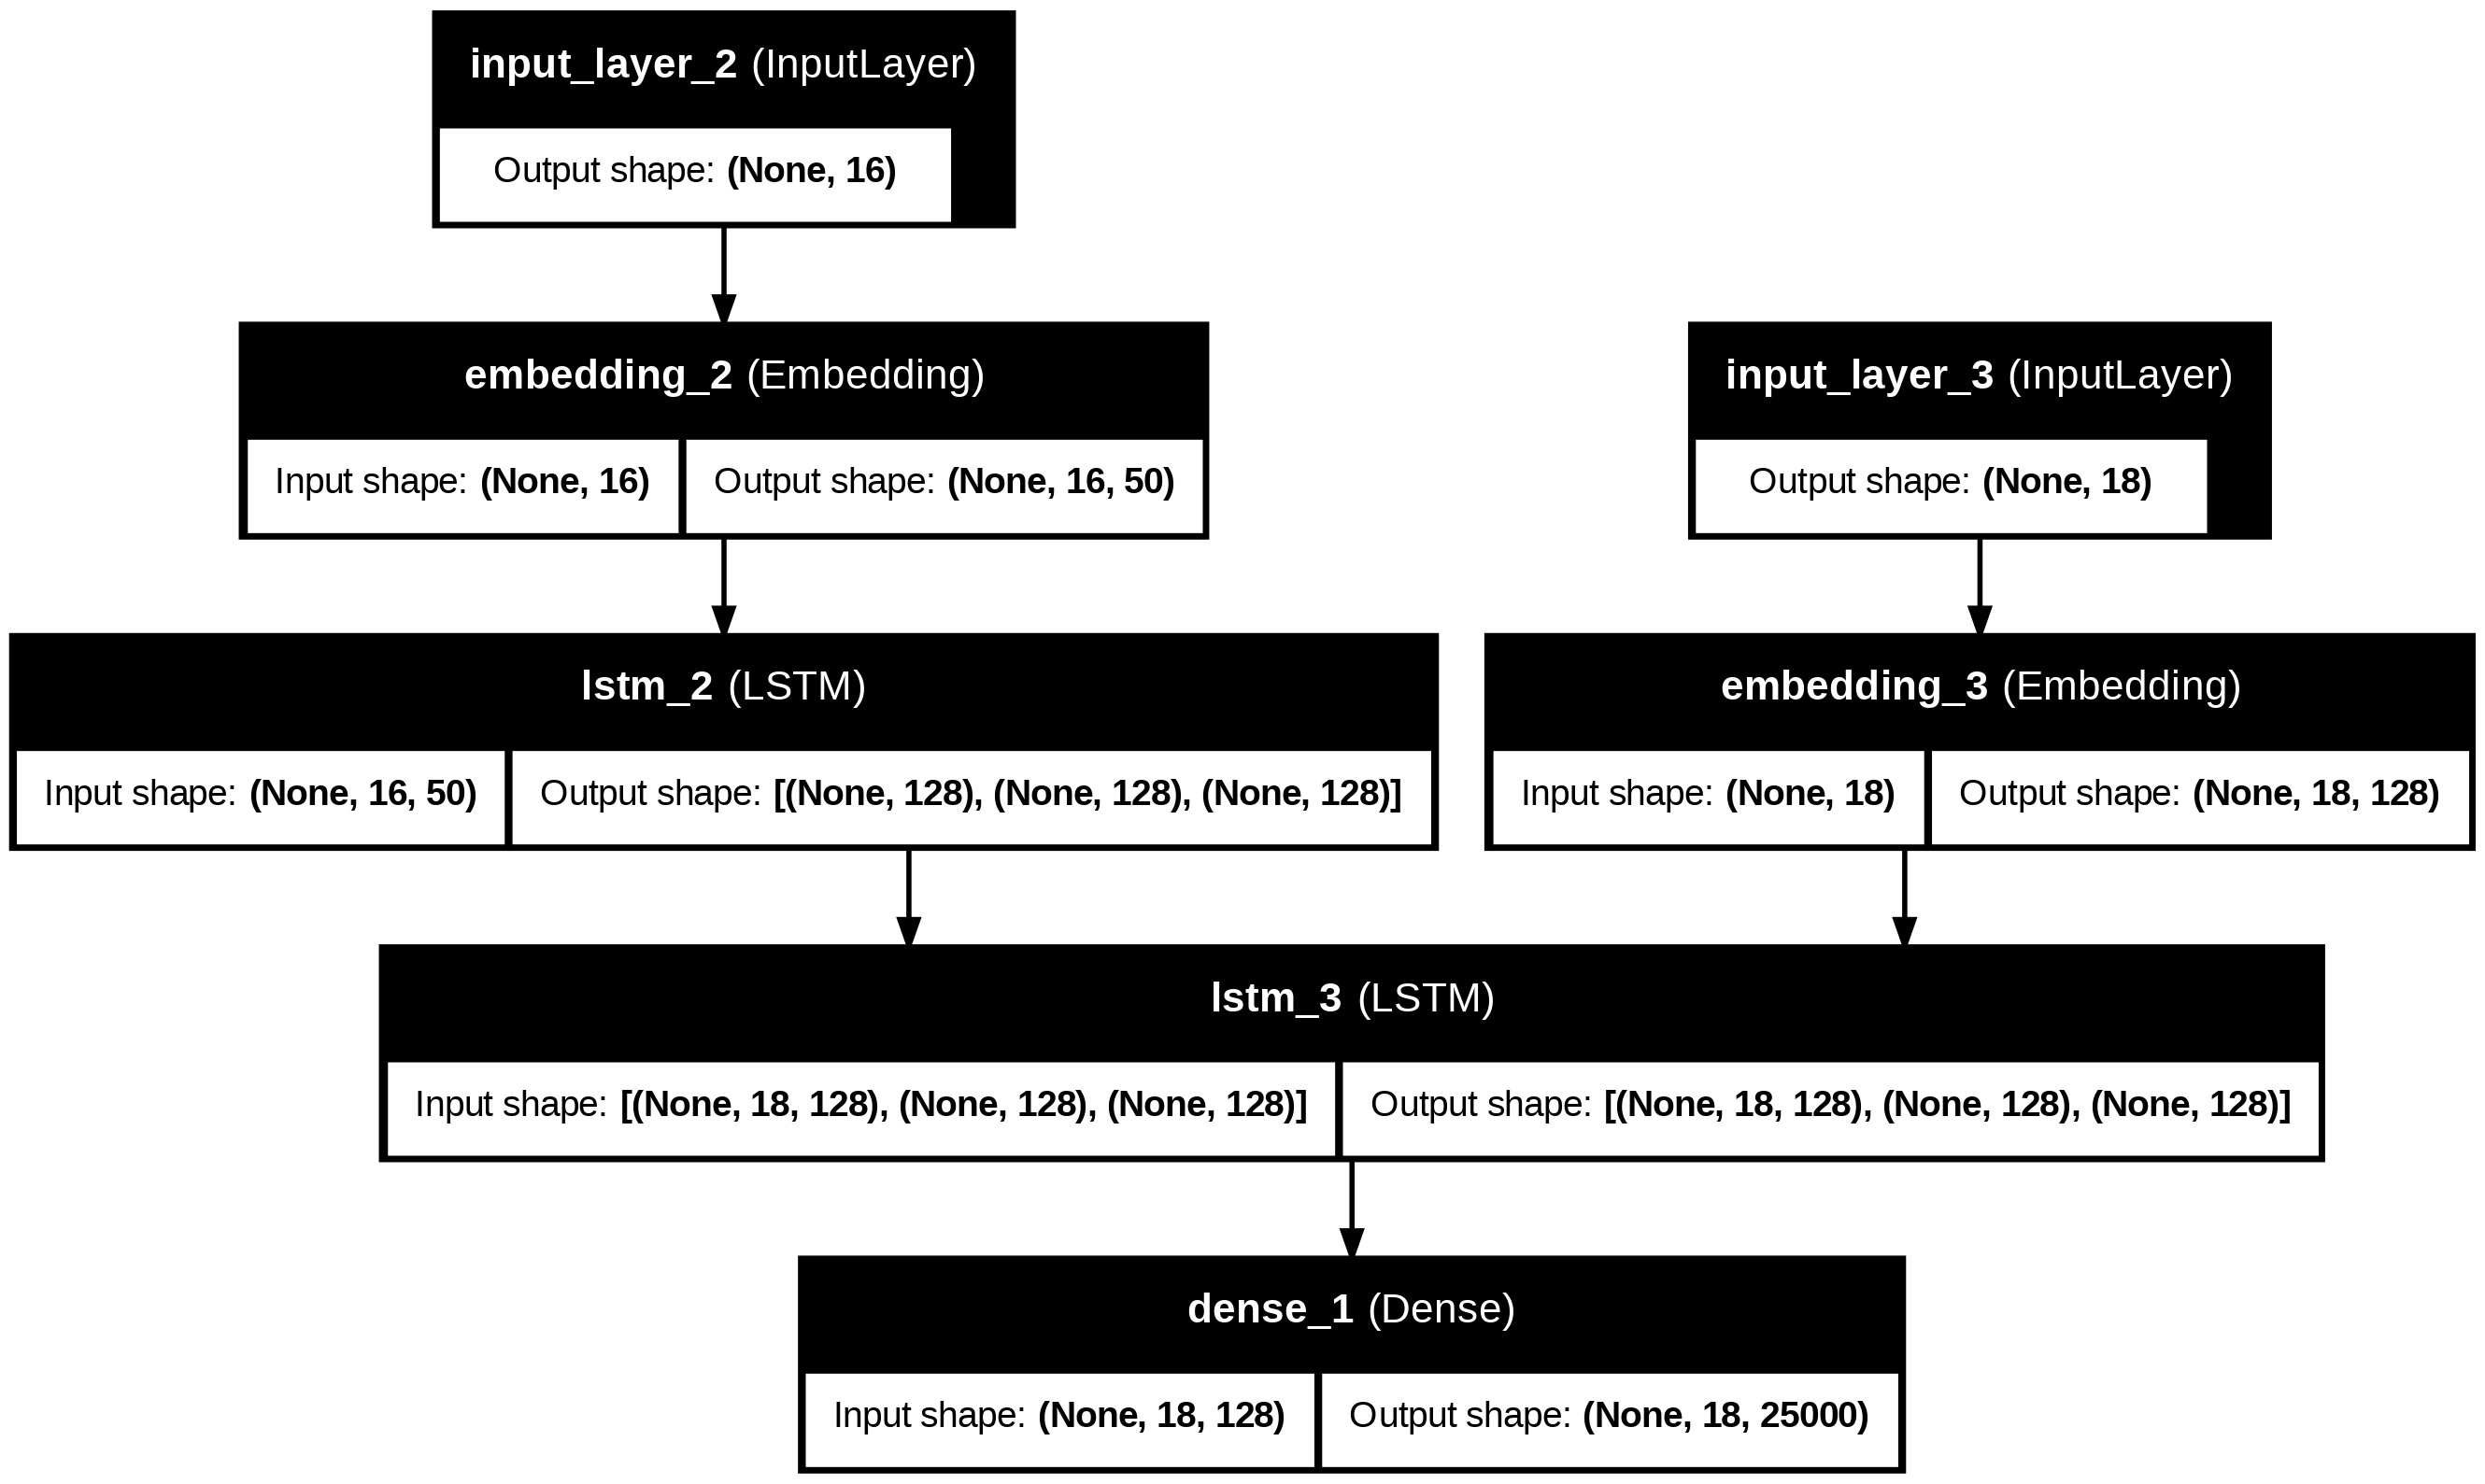

In [31]:
# Modelo completo (encoder+decoder) para poder entrenar
print("Arquitectura del modelo con 128 unidades:")
plot_model(m_128['model'], to_file='model_plot_128.png', show_shapes=True, show_layer_names=True)

Arquitectura del modelo con 64 unidades:


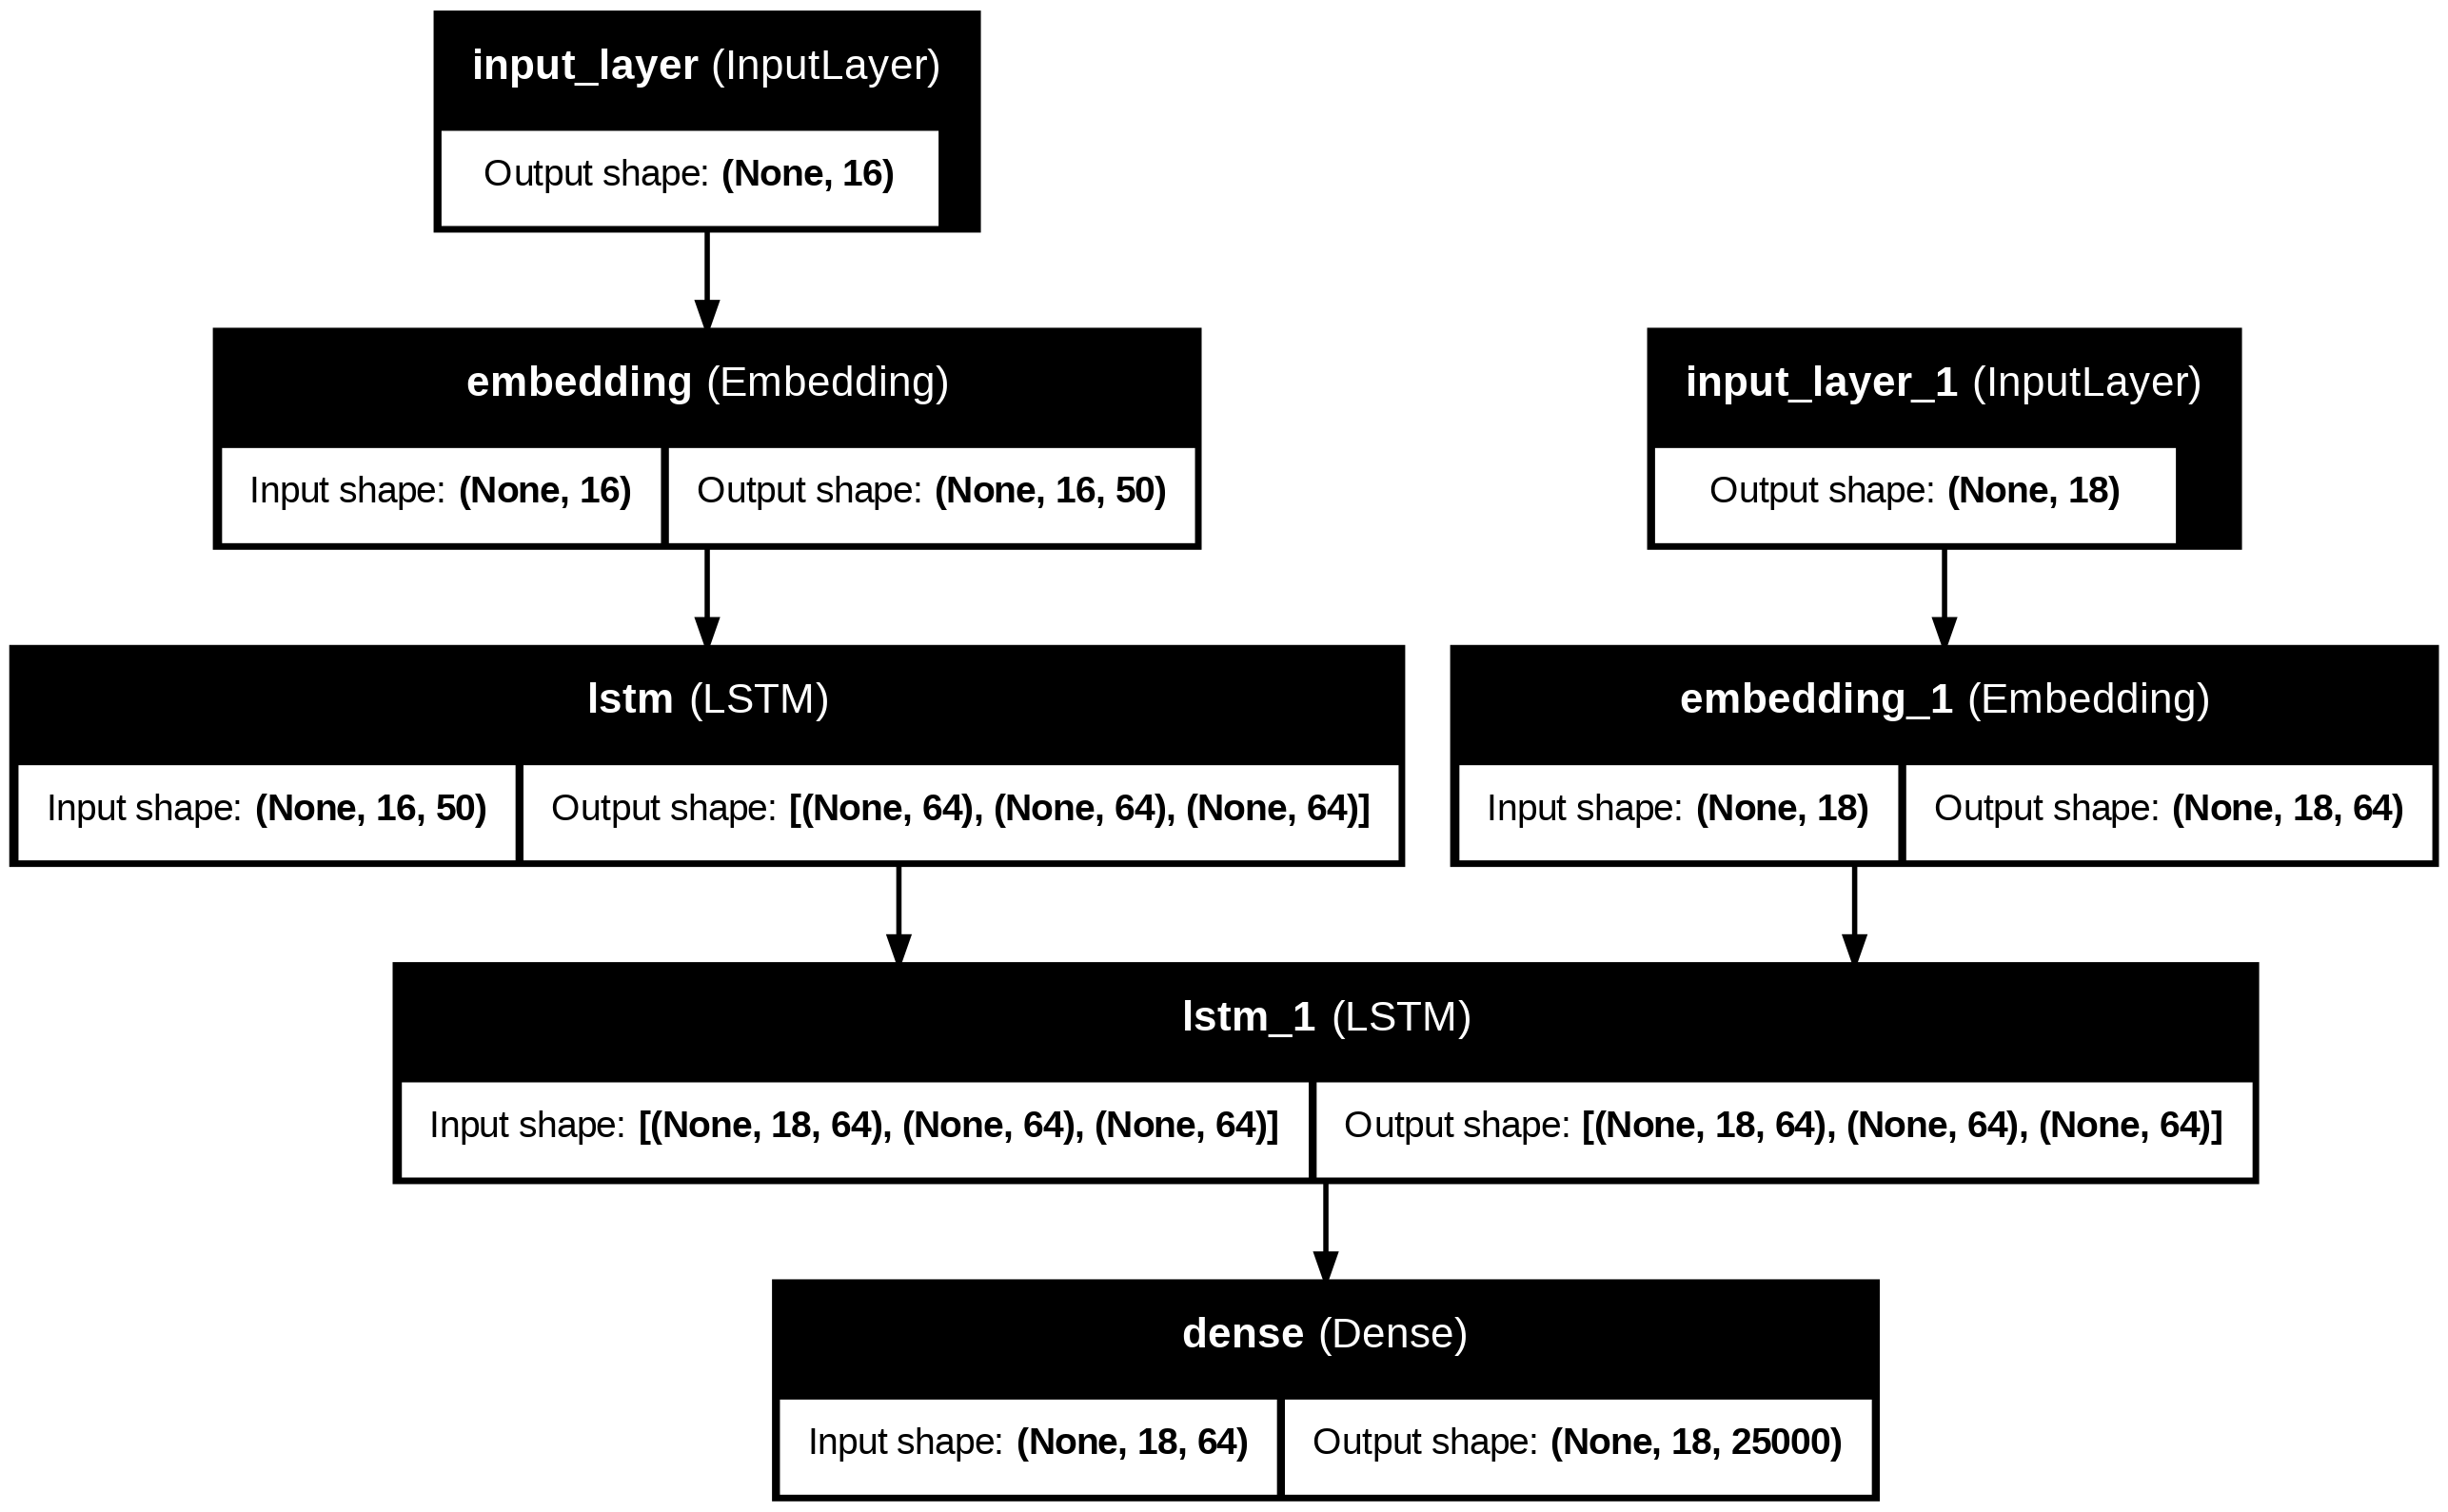

In [32]:
# Modelo completo (encoder+decoder) para poder entrenar
print("Arquitectura del modelo con 64 unidades:")
plot_model(m_64['model'], to_file='model_plot_64.png', show_shapes=True, show_layer_names=True)

Arquitectura del modelo con 256 unidades:


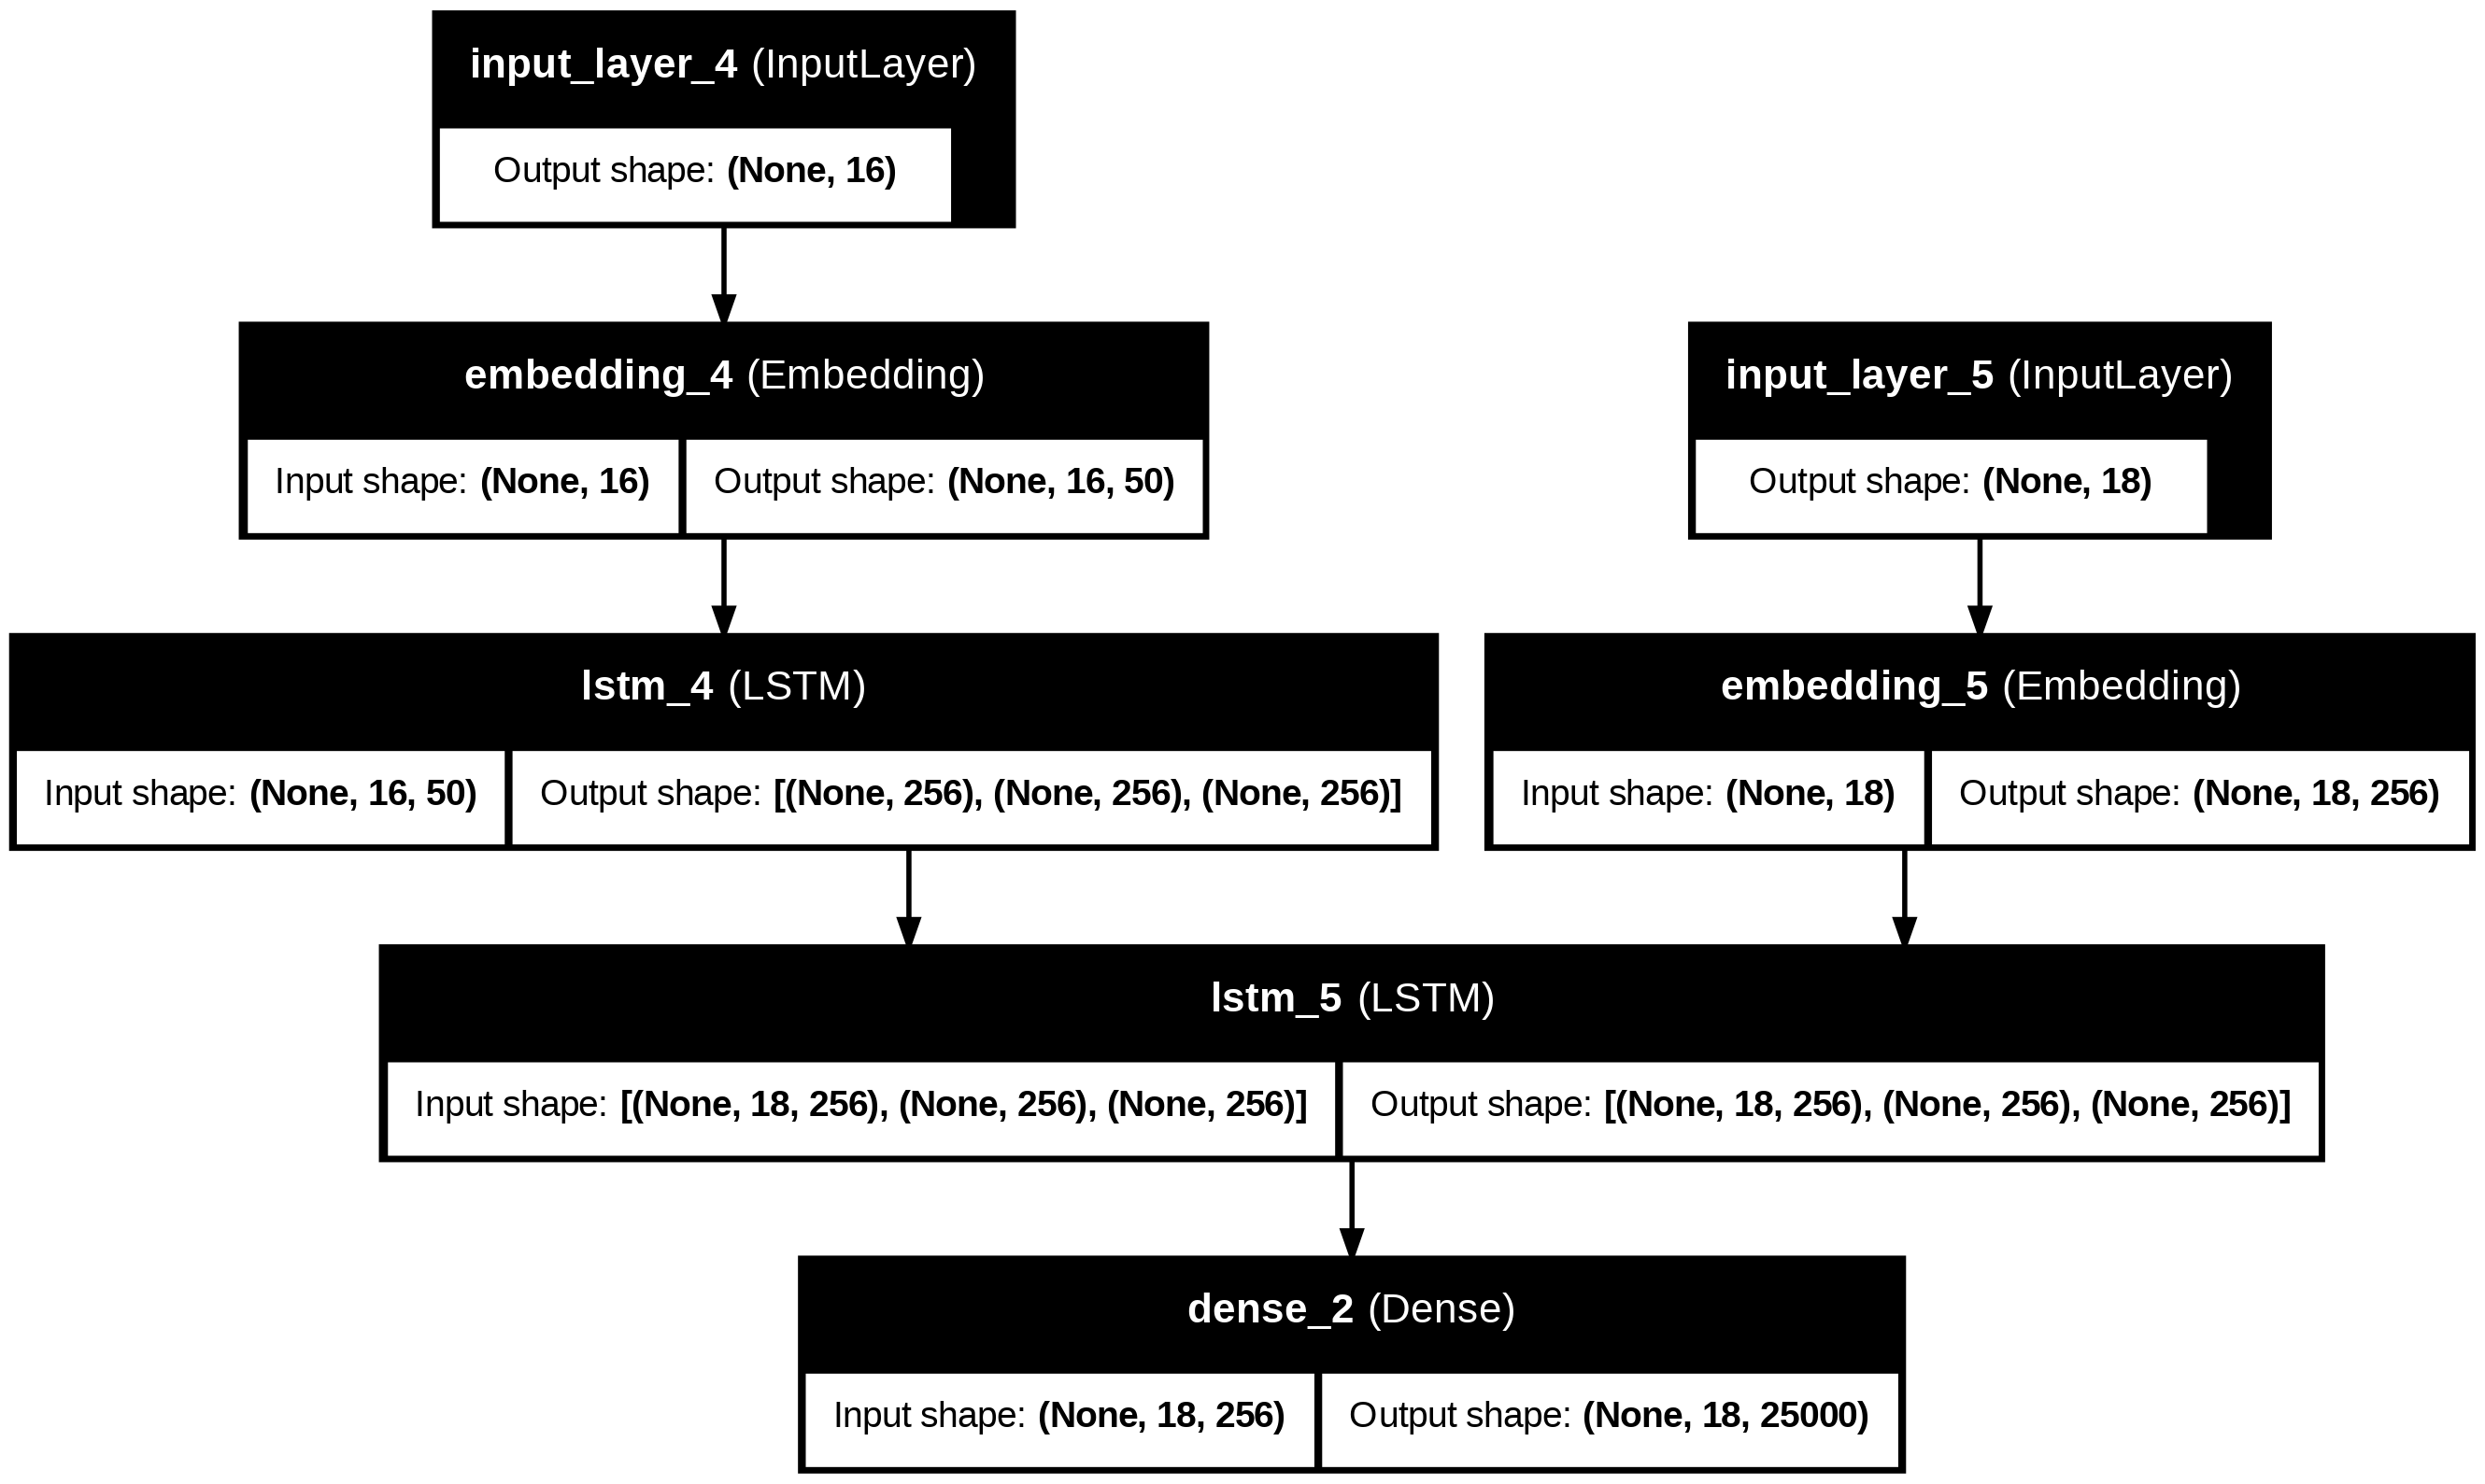

In [33]:
print("Arquitectura del modelo con 256 unidades:")
plot_model(m_256['model'], to_file='model_plot_256.png', show_shapes=True, show_layer_names=True)

#### Visualizar encoder

Arquitectura del encoder 64:


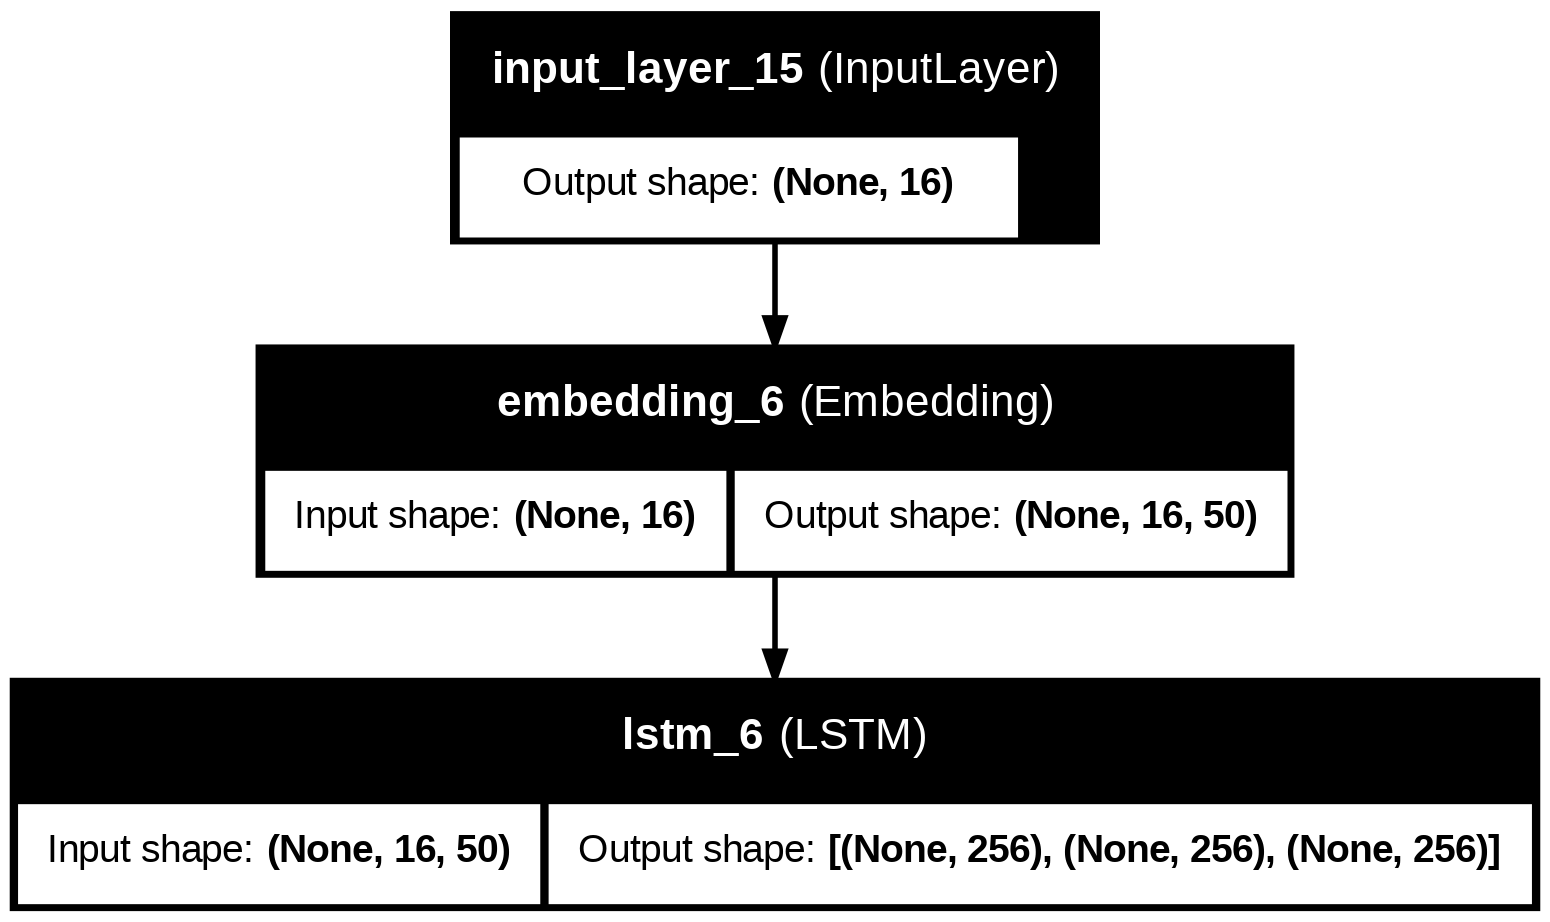

In [114]:
# Modelo solo encoder

# define inference encoder
encoder_model_64 = Model(m_64['encoder_inputs'], m_64['encoder_states'])
print("Arquitectura del encoder 64:")
plot_model(encoder_model_64, to_file='encoder_plot_64.png', show_shapes=True, show_layer_names=True)

In [35]:
# define inference encoder
encoder_model_128 = Model(m_128['encoder_inputs'], m_128['encoder_states'])
#print("Arquitectura del encoder 128:")
#plot_model(encoder_model_128, to_file='encoder_plot_128.png', show_shapes=True, show_layer_names=True)

Arquitectura del encoder 128:


In [36]:
encoder_model_256 = Model(m_256['encoder_inputs'], m_256['encoder_states'])
#print("Arquitectura del encoder 256:")
#plot_model(encoder_model_256, to_file='encoder_plot_256.png', show_shapes=True, show_layer_names=True)

Arquitectura del encoder 256:


#### Visualizar decoder

Arquitectura del decoder 64:


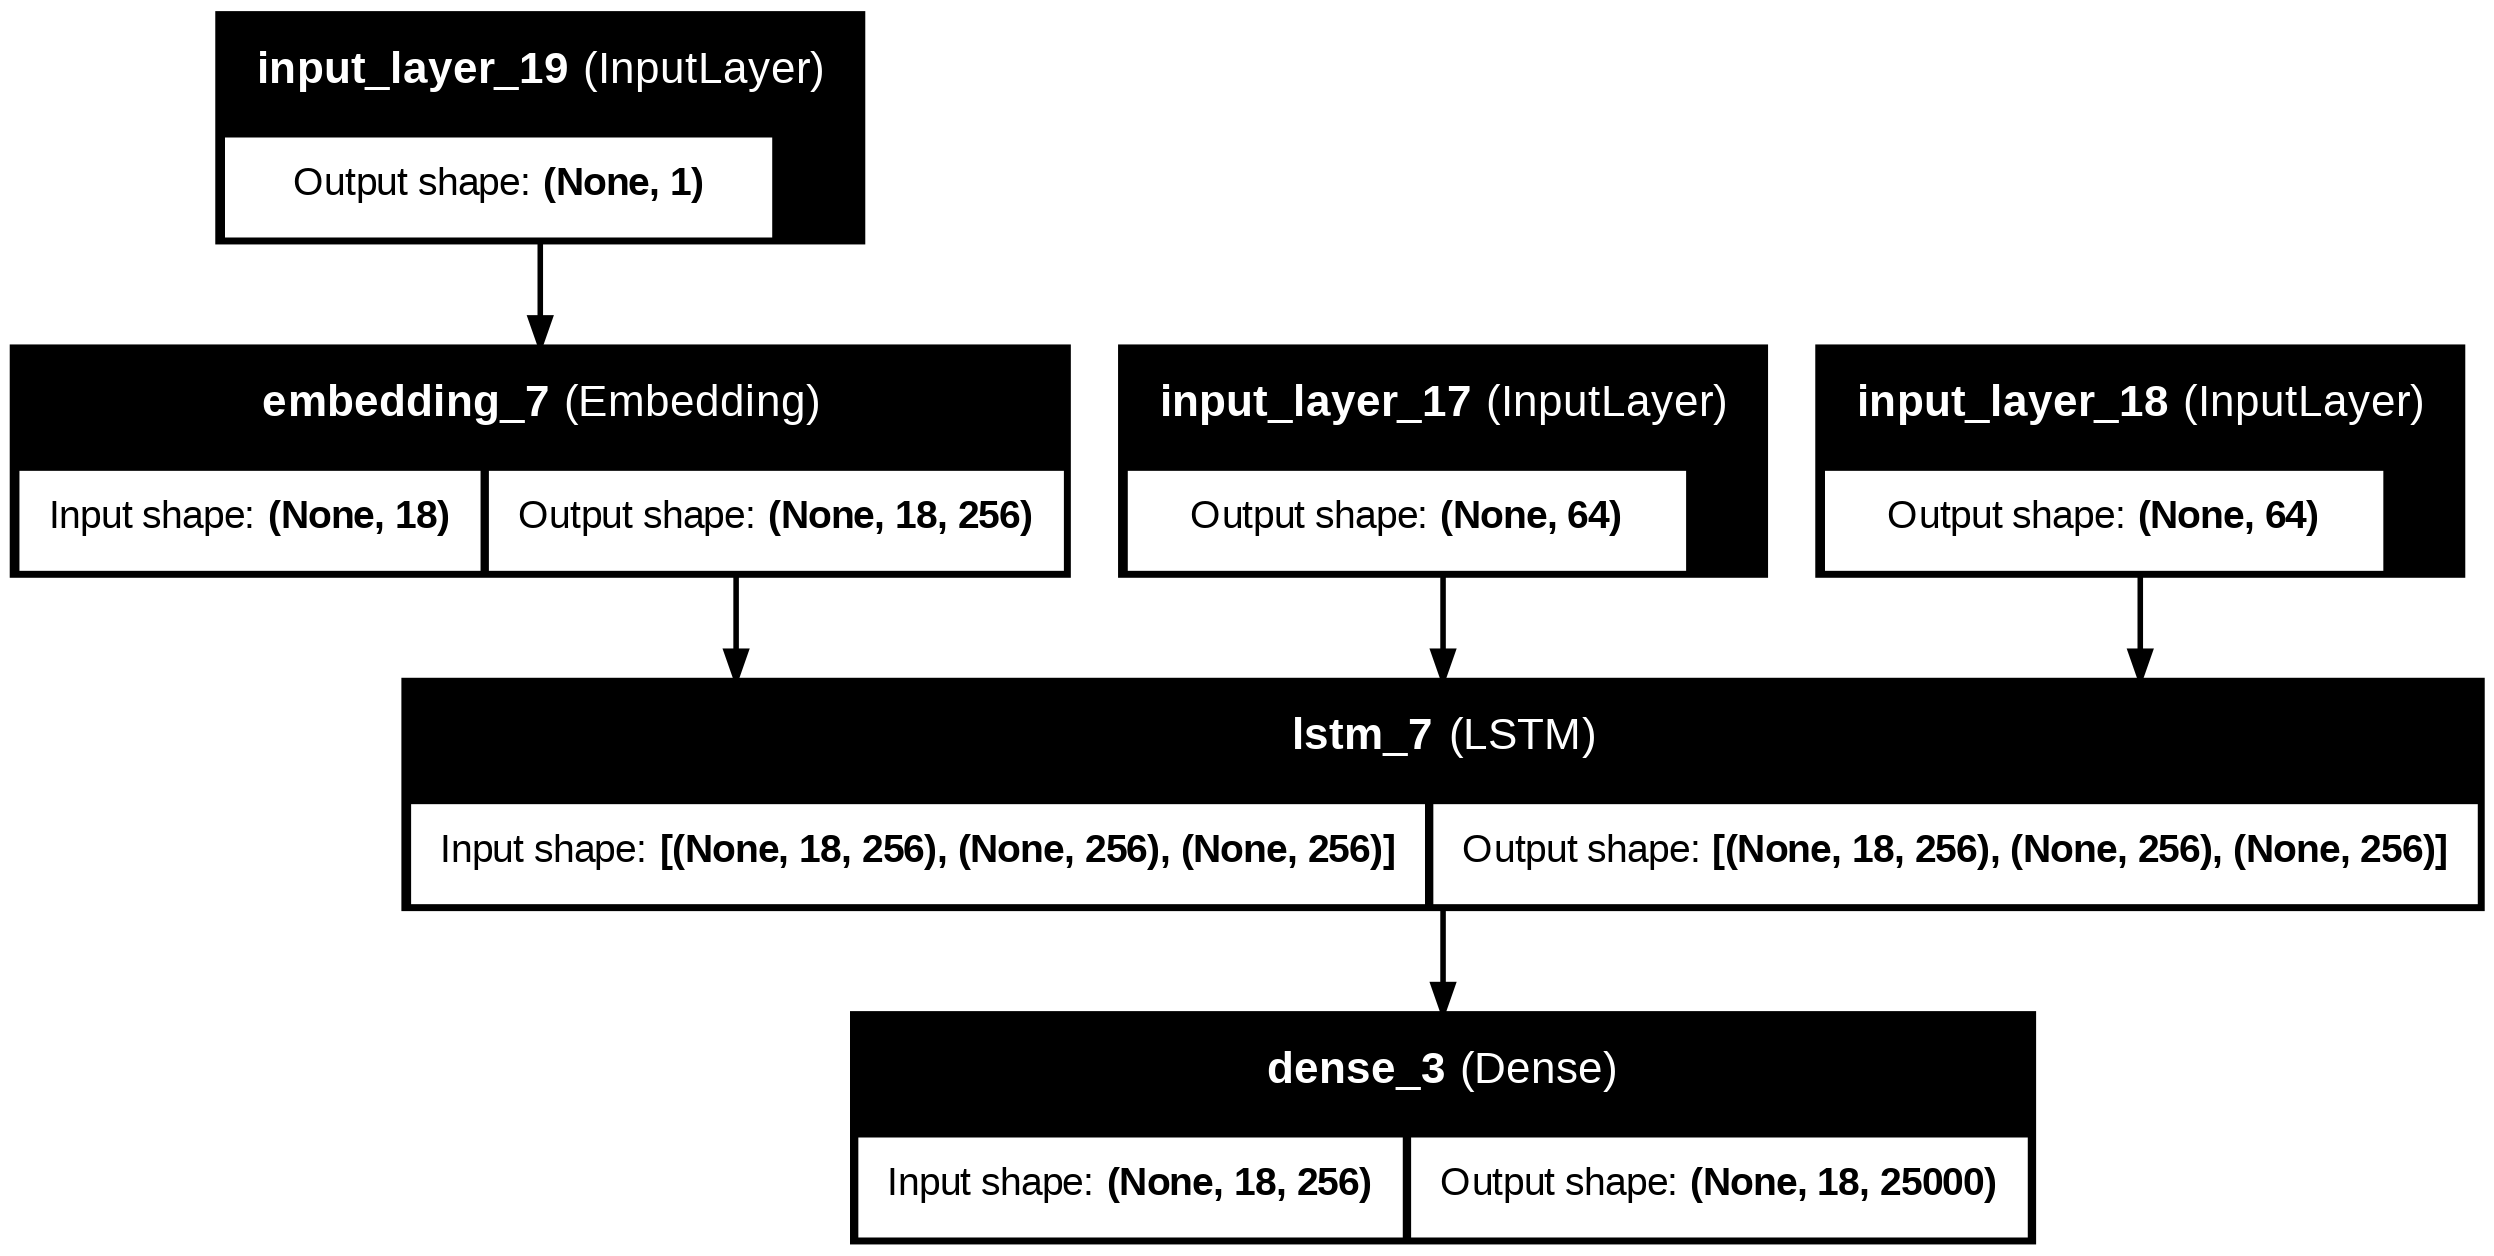

In [115]:
# Modelo solo decoder (para realizar inferencia)
n_units = 64
# define inference decoder
decoder_state_input_h_64 = Input(shape=(n_units,))
decoder_state_input_c_64 = Input(shape=(n_units,))
decoder_states_inputs_64 = [decoder_state_input_h_64, decoder_state_input_c_64]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x_64 = m_64['decoder_embedding_layer'](decoder_inputs_single)

decoder_outputs_64, state_h_64, state_c_64 = m_64['decoder_lstm'](decoder_inputs_single_x_64, initial_state=decoder_states_inputs_64)
decoder_states_64 = [state_h_64, state_c_64]
decoder_outputs_64 = m_64['decoder_dense'](decoder_outputs_64)
decoder_model_64 = Model([decoder_inputs_single] + decoder_states_inputs_64, [decoder_outputs_64] + decoder_states_64)

print("Arquitectura del decoder 64:")
plot_model(decoder_model_64, to_file='decoder_plot_64.png', show_shapes=True, show_layer_names=True)

In [38]:
# Modelo solo decoder (para realizar inferencia)
n_units = 128
# define inference decoder
decoder_state_input_h_128 = Input(shape=(n_units,))
decoder_state_input_c_128 = Input(shape=(n_units,))
decoder_states_inputs_128 = [decoder_state_input_h_128, decoder_state_input_c_128]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x_128 = m_128['decoder_embedding_layer'](decoder_inputs_single)

decoder_outputs_128, state_h_128, state_c_128 = m_128['decoder_lstm'](decoder_inputs_single_x_128, initial_state=decoder_states_inputs_128)
decoder_states_128 = [state_h_128, state_c_128]
decoder_outputs_128 = m_128['decoder_dense'](decoder_outputs_128)
decoder_model_128 = Model([decoder_inputs_single] + decoder_states_inputs_128, [decoder_outputs_128] + decoder_states_128)

#print("Arquitectura del decoder 128:")
#plot_model(decoder_model_128, to_file='decoder_plot_128.png', show_shapes=True, show_layer_names=True)

In [39]:
n_units = 256
# define inference decoder
decoder_state_input_h_256 = Input(shape=(n_units,))
decoder_state_input_c_256 = Input(shape=(n_units,))
decoder_states_inputs_256 = [decoder_state_input_h_256, decoder_state_input_c_256]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x_256 = m_256['decoder_embedding_layer'](decoder_inputs_single)
decoder_outputs_256, state_h_256, state_c_256 = m_256['decoder_lstm'](decoder_inputs_single_x_256, initial_state=decoder_states_inputs_256)
decoder_states_256 = [state_h_256, state_c_256]
decoder_outputs_256 = m_256['decoder_dense'](decoder_outputs_256)
decoder_model_256 = Model([decoder_inputs_single] + decoder_states_inputs_256, [decoder_outputs_256] + decoder_states_256)

#print("Arquitectura del decoder 256:")
#plot_model(decoder_model_256, to_file='decoder_plot_256.png', show_shapes=True, show_layer_names=True)

#### Entrenar modelos

In [116]:
# EarlyStopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [117]:
# Crear los DataGenerators para entrenamiento y validación
# Primero dividimos los datos en train/validation

from sklearn.model_selection import train_test_split

# Split de datos (80% train, 20% validation)
indices = np.arange(len(encoder_input_sequences))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Datos de entrenamiento
encoder_input_train = encoder_input_sequences[train_idx]
decoder_input_train = decoder_input_sequences[train_idx]
decoder_output_train = decoder_output_sequences[train_idx]

# Datos de validación
encoder_input_val = encoder_input_sequences[val_idx]
decoder_input_val = decoder_input_sequences[val_idx]
decoder_output_val = decoder_output_sequences[val_idx]

print(f"Datos de entrenamiento: {len(train_idx)} muestras")
print(f"Datos de validación: {len(val_idx)} muestras")


Datos de entrenamiento: 95171 muestras
Datos de validación: 23793 muestras


In [42]:
BATCH_SIZE = 64

train_generator = DataGenerator(
    encoder_input=encoder_input_train,
    decoder_input=decoder_input_train,
    decoder_output=decoder_output_train,
    num_words_output=num_words_output,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = DataGenerator(
    encoder_input=encoder_input_val,
    decoder_input=decoder_input_val,
    decoder_output=decoder_output_val,
    num_words_output=num_words_output,
    batch_size=BATCH_SIZE,
    shuffle=False
)

hist = m_64['model'].fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

models['n_units_64']['hist'] = hist

Epoch 1/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 205s 135ms/step - accuracy: 0.6374 - loss: 3.4360 - val_accuracy: 0.7006 - val_loss: 2.0569
Epoch 2/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - accuracy: 0.7072 - loss: 1.9632 - val_accuracy: 0.7212 - val_loss: 1.8237
Epoch 3/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 200s 134ms/step - accuracy: 0.7253 - loss: 1.7453 - val_accuracy: 0.7302 - val_loss: 1.7099
Epoch 4/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - accuracy: 0.7352 - loss: 1.6172 - val_accuracy: 0.7359 - val_loss: 1.6357
Epoch 5/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 199s 133ms/step - accuracy: 0.7422 - loss: 1.5205 - val_accuracy: 0.7409 - val_loss: 1.5803
Epoch 6/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - accuracy: 0.7485 - loss: 1.4449 - val_accuracy: 0.7445 - val_loss: 1.5423
Epoch 7/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - accuracy: 0.7536 - loss: 1.3810 - val_accuracy: 0.7474 - val_loss: 1.5139
Epoch 8/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - ac

In [118]:
train_dataset = create_tf_dataset(encoder_input_train, decoder_input_train,
                                   decoder_output_train, num_words_output,
                                   batch_size=64, shuffle=True)
val_dataset = create_tf_dataset(encoder_input_val, decoder_input_val,
                                 decoder_output_val, num_words_output,
                                 batch_size=64, shuffle=False)

hist = m_64['model'].fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

models['n_units_64']['hist'] = hist

Epoch 1/50
   1487/Unknown 140s 93ms/step - accuracy: 0.6662 - loss: 2.6838

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 166s 110ms/step - accuracy: 0.6662 - loss: 2.6831 - val_accuracy: 0.7258 - val_loss: 1.7562
Epoch 2/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 163s 110ms/step - accuracy: 0.7339 - loss: 1.6349 - val_accuracy: 0.7479 - val_loss: 1.5040
Epoch 3/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 163s 110ms/step - accuracy: 0.7564 - loss: 1.3578 - val_accuracy: 0.7607 - val_loss: 1.3818
Epoch 4/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 163s 109ms/step - accuracy: 0.7727 - loss: 1.1789 - val_accuracy: 0.7684 - val_loss: 1.3167
Epoch 5/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 164s 110ms/step - accuracy: 0.7876 - loss: 1.0399 - val_accuracy: 0.7736 - val_loss: 1.2821
Epoch 6/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 163s 110ms/step - accuracy: 0.7998 - loss: 0.9347 - val_accuracy: 0.7768 - val_loss: 1.2644
Epoch 7/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 164s 110ms/step - accuracy: 0.8133 - loss: 0.8450 - val_accuracy: 0.7792 - val_loss: 1.2591
Epoch 8/50
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 163s 110ms/step - accuracy: 0.8

In [45]:
train_dataset = create_tf_dataset(encoder_input_train, decoder_input_train,
                                   decoder_output_train, num_words_output,
                                   batch_size=128, shuffle=True)
val_dataset = create_tf_dataset(encoder_input_val, decoder_input_val,
                                 decoder_output_val, num_words_output,
                                 batch_size=128, shuffle=False)

hist = m_128['model'].fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

models['n_units_128']['hist'] = hist

Epoch 1/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 126s 167ms/step - accuracy: 0.6368 - loss: 3.5068 - val_accuracy: 0.6952 - val_loss: 2.0798
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.7018 - loss: 1.9871 - val_accuracy: 0.7196 - val_loss: 1.8289
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.7247 - loss: 1.7468 - val_accuracy: 0.7322 - val_loss: 1.6929
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.7378 - loss: 1.5904 - val_accuracy: 0.7402 - val_loss: 1.5946
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.7468 - loss: 1.4718 - val_accuracy: 0.7462 - val_loss: 1.5236
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.7540 - loss: 1.3771 - val_accuracy: 0.7513 - val_loss: 1.4697
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.7618 - loss: 1.2914 - val_accuracy: 0.7554 - val_loss: 1.4292
Epoch 8/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 123s 165ms/step - accuracy: 0.7673 -

In [46]:
train_dataset = create_tf_dataset(encoder_input_train, decoder_input_train,
                                   decoder_output_train, num_words_output,
                                   batch_size=256, shuffle=True)
val_dataset = create_tf_dataset(encoder_input_val, decoder_input_val,
                                 decoder_output_val, num_words_output,
                                 batch_size=256, shuffle=False)

hist = m_256['model'].fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

models['n_units_256']['hist'] = hist

Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 132s 348ms/step - accuracy: 0.6256 - loss: 3.5781 - val_accuracy: 0.6911 - val_loss: 2.1271
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.6960 - loss: 2.0440 - val_accuracy: 0.7138 - val_loss: 1.8608
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.7200 - loss: 1.7749 - val_accuracy: 0.7303 - val_loss: 1.6981
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 348ms/step - accuracy: 0.7351 - loss: 1.6008 - val_accuracy: 0.7406 - val_loss: 1.5886
Epoch 5/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 346ms/step - accuracy: 0.7466 - loss: 1.4648 - val_accuracy: 0.7475 - val_loss: 1.5085
Epoch 6/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 345ms/step - accuracy: 0.7557 - loss: 1.3575 - val_accuracy: 0.7537 - val_loss: 1.4488
Epoch 7/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 128s 344ms/step - accuracy: 0.7639 - loss: 1.2648 - val_accuracy: 0.7580 - val_loss: 1.4022
Epoch 8/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 129s 345ms/step - accuracy: 0.7712 -

#### Comprar modelos

Resultados del modelo con 64 unidades:


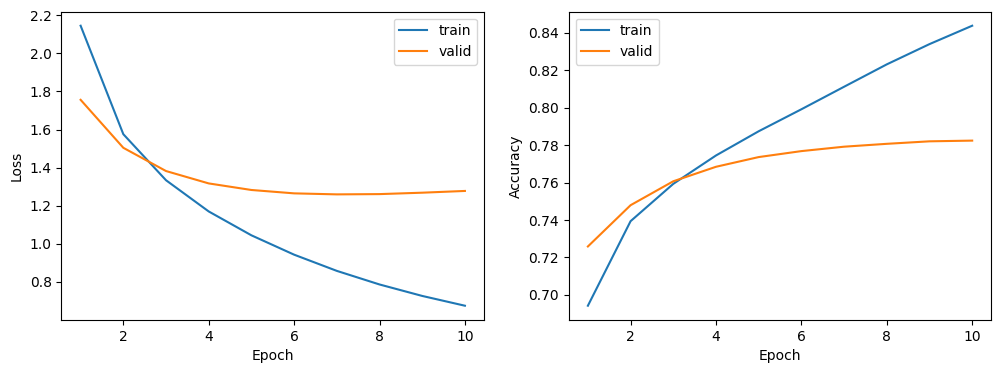

Resultados del modelo con 128 unidades:


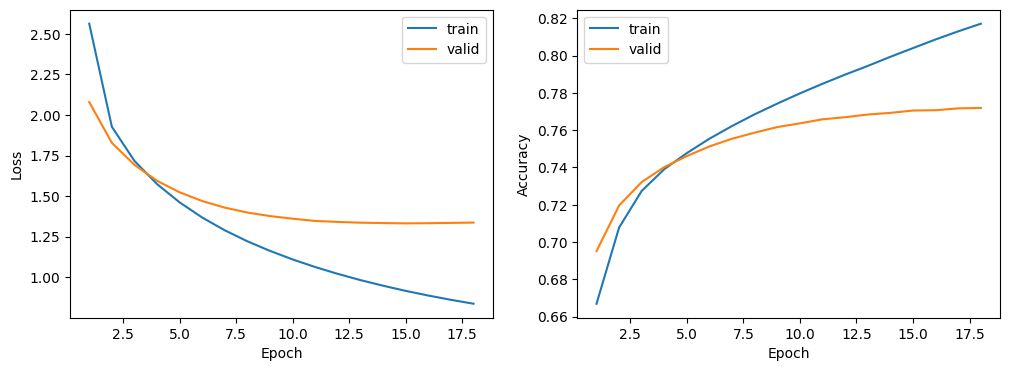

Resultados del modelo con 256 unidades:


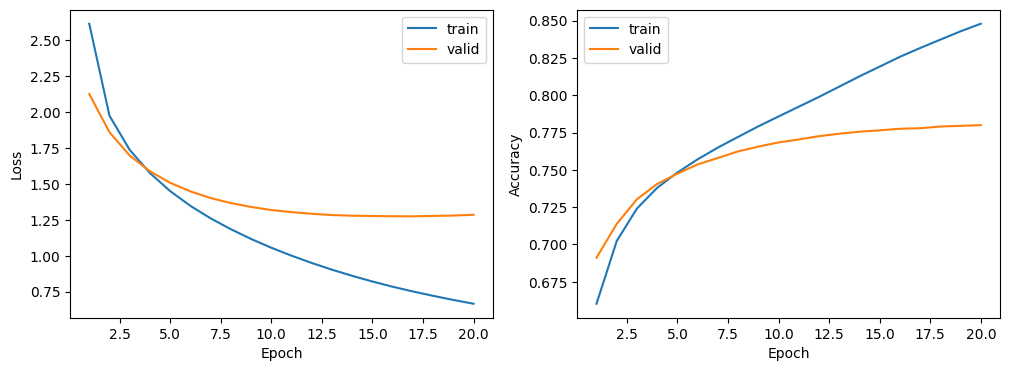

In [119]:
for n_units in n_units_list:
    hist = models[f'n_units_{n_units}']['hist']
    print(f"Resultados del modelo con {n_units} unidades:")
    # Entrenamiento
    epoch_count = range(1, len(hist.history['accuracy']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
    sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Se selecciona el modelo con mejores métricas.

In [120]:
for name, model_data in models.items():
    history = model_data['hist']
    if history and 'accuracy' in history.history:
        current_val_loss = history.history['accuracy'][-1]
        print(f"Model {name}: Final Accuracy = {current_val_loss:.4f}")

Model n_units_64: Final Accuracy = 0.8438
Model n_units_128: Final Accuracy = 0.8171
Model n_units_256: Final Accuracy = 0.8480


In [50]:
best_model = models['n_units_256']
best_encoder = encoder_model_256
best_decoder = decoder_model_256

Se entrenaron tres modelos seq2seq con arquitectura encoder-decoder LSTM variando el número de unidades: 64, 128 y 256. 

Los principales hallazgos son:

1. **Mejor modelo:** El modelo con **256 unidades LSTM** obtuvo el mejor rendimiento con una accuracy del 84.80%, por lo que fue seleccionado para la inferencia.

2. **Capacidad vs. Generalización:** Aunque el modelo de 256 unidades tiene mayor capacidad de aprendizaje (más parámetros), no presentó signos evidentes de overfitting severo gracias al uso de EarlyStopping con `patience=3`.

3. **Eficiencia del entrenamiento:** create_tf_dataset resultó ~18-20% más rápido que el DataGenerator tradicional.

4. **Convergencia:** Todos los modelos mostraron una curva de aprendizaje estable, reduciendo consistentemente el loss tanto en entrenamiento como en validación durante las primeras épocas.


### 5 - Inferencia

```
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
```



In [51]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [52]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = best_encoder.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = best_decoder.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [83]:
def translate_sentence_beam_search_stochastic(
    input_seq,
    beam_width=3,
    temperature=1.0,
    max_out_len=50,
    eps=1e-12
):
    """
    beam_width: número de beams a mantener
    temperature: >0 (si es 1.0 comportamiento normal)
    stochastic: si True realiza muestreo estocástico; si False usa top-k determinista
    eps: para estabilidad numérica en logs
    """

    # Predecir estados iniciales del encoder (puede ser lista [h, c] o similar)
    states_value = best_encoder.predict(input_seq)

    # Lista de secuencias: (tokens_list, accumulated_score, states)
    # score será acumulado de -log(p) (menor = mejor)
    sequences = [(['<sos>'], 0.0, states_value)]

    for _ in range(max_out_len):
        all_candidates = []

        # Si todas las secuencias ya terminaron en <eos>, podemos romper
        if all(seq[-1] == '<eos>' for seq, _, _ in sequences):
            break

        for seq, score, states in sequences:
            # si la secuencia ya terminó, la mantengo tal cual
            if seq[-1] == '<eos>':
                all_candidates.append((seq, score, states))
                continue

            # preparar target token
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = word2idx_outputs.get(seq[-1], 0)

            # predecir next token probabilities y nuevos estados
            output_tokens, h, c = best_decoder.predict([target_seq] + states)
            logits = output_tokens[0, 0, :]

            # aplico temperatura y convierto a probabilidades de forma estable
            logits = logits / float(temperature)
            logits = logits - np.max(logits)
            exp_logits = np.exp(logits)
            probs = exp_logits / (np.sum(exp_logits) + eps)

            V = probs.shape[0]

            # Muestreo estocástico: elijo candidatos muestreando sin reemplazo
            k = min(beam_width, V)
            try:
              if probs <= 0.001:
                # En casos probs muy pequeñas, fallback a top-k determinista
                sampled_indices = np.argsort(probs)[-k:][::-1]
              else:
                sampled_indices = np.random.choice(V, size=k, replace=False, p=probs)
            except ValueError:
              # Si hay error vuelvo al modo determinista
              sampled_indices = np.argsort(probs)[-k:][::-1]

            candidate_indices = sampled_indices

            for idx in candidate_indices:
                token = idx2word_target.get(int(idx), '')
                # proteger de log(0)
                p = max(probs[int(idx)], eps)
                new_score = score - np.log(p)  # acumulamos -log prob (menor es mejor)
                new_states = [np.copy(h), np.copy(c)] if isinstance(h, np.ndarray) else [h, c]
                candidate = (seq + [token], new_score, new_states)
                all_candidates.append(candidate)

        # me quedo con las mejores beam_width secuencias por score
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # elijo la mejor secuencia que no termine en <eos> preferentemente
    best_sequence = sequences[0][0]
    if '<eos>' in best_sequence:
        best_sequence = best_sequence[:best_sequence.index('<eos>')]

    # quito <sos> si está al inicio
    if len(best_sequence) > 0 and best_sequence[0] == '<sos>':
        best_sequence = best_sequence[1:]

    return ' '.join(best_sequence)


In [57]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
-
Input: Don't push it.
Response: no lo subestimes


Tiene el contexto, pero no acierta la frase.

In [ ]:
# Ejemplo de uso con muestreo aleatorio
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence_beam_search_stochastic(input_seq, temperature=0.8)
print('-')
print('Input:', input_sentences[i])
print('Response (sampling):', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

Traduce correctamente.

In [91]:
def generate_translations(input_test="", bw=3, temperature=1.0):
    if input_test == "":
        # Seleccionar una oración al azar del dataset
        i = np.random.choice(len(input_sentences))
        encoder_sequence_test = encoder_input_sequences[i:i+1]
        print('Input:', input_sentences[i])
    else:
        # Procesar la oración de entrada
        integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
        print("Representacion en vector de tokens de ids", integer_seq_test)
        encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
        print("Padding del vector:", encoder_sequence_test)

        print('Input:', input_test)

    translation = translate_sentence(encoder_sequence_test)
    translation_2 = translate_sentence_beam_search_stochastic(encoder_sequence_test, beam_width=bw, temperature=temperature)

    print('Response:', translation)
    print('Response (Beam Search):', translation_2)


In [98]:
input_test = "My mother say hi."
generate_translations(input_test=input_test, bw=5, temperature=0.2)

Representacion en vector de tokens de ids [18, 199, 126, 2318]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0   18  199
   126 2318]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━

Con ambas generaciones se acierta a la madre, pero ninguna acierta la acción de la misma.

In [101]:
input_test = "Every end is a new beginning"
generate_translations(input_test=input_test, bw=15, temperature=0.1)

Representacion en vector de tokens de ids [148, 515, 7, 6, 135, 1057]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0  148  515    7    6
   135 1057]]
Input: Every end is a new beginning
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

La generación determinista estuvo mucho más cerca al menos del origen de la frase.

In [102]:
input_test = "Happy new year!"
generate_translations(input_test=input_test, bw=5, temperature=0.2)

Representacion en vector de tokens de ids [195, 135, 235]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0 195 135 235]]
Input: Happy new year!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/

Se tradujo casi perfectamente con beam search.

In [103]:
input_test = "I know what you mean"
generate_translations(input_test=input_test, bw=5, temperature=0.1)

Representacion en vector de tokens de ids [2, 37, 23, 4, 533]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   2  37  23   4 533]]
Input: I know what you mean
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

Se tradujo perfectamente con beam search.

In [104]:
input_test = "Give me a break"
generate_translations(input_test=input_test, bw=3, temperature=0.1)

Representacion en vector de tokens de ids [140, 17, 6, 645]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0 140  17   6 645]]
Input: Give me a break
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Response: dame un respiro
Response (Beam Search): dame un respiro


Se tradujo casi perfectamente con ambas estrategias.

In [108]:
input_test = "The only thing we have to fear is fear itself"
generate_translations(input_test=input_test, bw=3, temperature=0.2)

Representacion en vector de tokens de ids [1, 128, 273, 26, 15, 3, 1018, 7, 1018, 1951]
Padding del vector: [[   0    0    0    0    0    0    1  128  273   26   15    3 1018    7
  1018 1951]]
Input: The only thing we have to fear is fear itself
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41m

Cuando no tiene idea de qué palabra usar, suele usar la palabra `tom` como un comodín.

#### Conclusión de la Inferencia

Se implementaron y evaluaron dos estrategias de generación de texto para el modelo traductor seq2seq:

**Estrategias de decodificación:**

| Estrategia | Descripción | Características |
|------------|-------------|-----------------|
| Greedy (Determinista) | Selecciona el token con mayor probabilidad en cada paso | Rápida, pero puede generar traducciones subóptimas |
| Beam Search Estocástico | Mantiene múltiples hipótesis y aplica muestreo con temperatura | Mayor variedad y calidad en las traducciones |

**Resultados observados:**

| Frase de entrada | Traducción Greedy | Traducción Beam Search | Calidad |
|------------------|-------------------|------------------------|---------|
| "Don't push it" | no lo subestimes | - | ⚠️ Contexto correcto, frase incorrecta |
| "My mother say hi" | mi madre se ha ido | mi madre se casó | ⚠️ Identifica "madre" pero no la acción |
| "Every end is a new beginning" | todos los elefantes son diferentes en recursos naturales | el inglés aún no es fácil | ❌ Ambas incorrectas |
| "Happy new year!" | no te lo creerá | ¡feliz año | ✅ Beam Search superior |
| "I know what you mean" | sé lo que me estás preguntando | sé lo que te refieres | ✅ Beam Search más preciso |
| "Give me a break" | dame un respiro | dame un respiro | ✅ Ambas correctas |
| "The only thing we have to fear is fear itself" | el de la primera vez que tom es culpa de la guerra | lo único que quiere saber es culpa de ti | ❌ Usa "Tom" como comodín |

**Observaciones clave:**

1. **Beam Search con temperatura baja (0.1-0.2)** generalmente produce mejores traducciones al explorar múltiples caminos y reducir la aleatoriedad.

2. **Frases comunes del dataset** se traducen correctamente, lo que indica que el modelo aprendió patrones frecuentes del corpus.

3. **Limitaciones identificadas:**
   - Frases complejas o fuera del dominio del entrenamiento generan traducciones incorrectas
   - El modelo usa "Tom" como comodín cuando no encuentra una traducción adecuada (sesgo del dataset)
   - Dificultad con expresiones idiomáticas y frases largas

4. **Hiperparámetros óptimos:** beam_width=3-5 y temperature=0.1-0.2 ofrecen un buen balance entre diversidad y precisión.
